# 1. Introduction

Welcome to _A Guided Tour of Proto-Elamite_! This is a suite of data exploration tools intended to provide an easy introduction to working with the proto-Elamite corpus. 
This notebook reproduces and elaborates on the results of Born et al. (2019), and we recommend you consult the paper for background information prior to using this notebook.

## 1.1. Using this Notebook

If you are running this notebook locally or on Binder, click on a block of code and press Shift-Enter to run it. The output will print out beneath the code. If you are on github or nbviewer, interactivity is disabled, but you can still see the default output from each cell.

Readers are encouraged to edit parameter settings to see how they affect the output. Parameters of interest are usually explained with comments at the beginning of each code block. We summarize the function of each code block in the surrounding text, but readers with a programming background will find additional implementation details left as comments in the code.

Some code blocks rely on data computed in previous cells, so it is recommended to run them in the order they appear.

# 2. Setup

The transcribed proto-Elamite corpus used by Born et al. (2019) is available in the file `data/cdli_atf_20180602.txt.bz2`. Importing the `pype` package will load this data automatically:

In [1]:
import pype # Main set of tools for working with proto-Elamite.
import pe_toolkit_utils as util # Helper functions; moved to their own package to reduce clutter in the notebook.
print("Packages imported.")

Packages imported.


`pype` provides a basic interface for accessing `Tablet` objects, which themselves expose methods for retrieving information about a text: 

In [2]:
print("Printing data about an example tablet:")
# pype.tablets is a list of Tablet objects:
for tablet in pype.tablets:
    # Public members include the tablet's CDLI catalogue number, 
    # a boolean recording whether or not the tablet is sealed, 
    # and the value of the tablet's header if it has one.
    print("\tCDLI #%s:\n\tTablet is sealed?\t%s\n\tTablet header:\t\t%s" % (
        tablet.cdliNo,
        tablet.sealed,
        tablet.header
    ))
    
    # Tablets will prettyprint by default:
    # print( tablet )
    
    # It is possible to retrieve the contents of the tablet as a 
    # space-delimited string of sign names:
    # linearized_tablet = tablet.linearize( excludeNumeric = False )
    # To ignore the numeric signs, use excludeNumeric = True.
    
    # Retrieve the contents of the tablet line-by-line:
    print("\tTransliteration:")
    for entry, number in tablet.getLines( excludeNumeric = False ):
        print('\t  ',entry,',',number)
    # To ignore the numeric signs, use excludeNumeric = True:
    # for entry in tablet.getLines( excludeNumeric = True ):
    #     print('\t  ',entry)
    break

Printing data about an example tablet:
	CDLI #P009402:
	Tablet is sealed?	False
	Tablet header:		None
	Transliteration:
	   [...] , 
	   [...] , 2(N01)
	   X , 2(N01)#
	   [...] , 1(N01)#
	   M131~E? , 2(N14)
	   M136~W , 1(N01)#
	   X , 3(N01)#
	   X , [...]


# 3. Corpus Overview

We begin by printing out basic information about the corpus:

In [3]:
# Some tablets only contain numeric or unreadable signs.
# Let's remove them from the corpus:
import re
unreadable_signs_regex = r"\[...\]|X\??"
tablets_with_real_content = [t for t in pype.tablets 
                             if re.sub( unreadable_signs_regex, "", 
                                       t.linearize( excludeNumeric=True ).upper() 
                                      ).strip() != '']

# Signs are often annotated to mark whether they are damaged, 
# hard to read, inferred from context, etc. This code removes
# those annotations to find a list of distinct signs used in the corpus:
transliteration_annotations_regex = r"\[...\]|\?|#|!|\[|\]|<|>"
signary = set(
              re.sub( transliteration_annotations_regex, "",
                     sign.upper()
                    ) for t in pype.tablets 
                      for sign in t.linearize( excludeNumeric = False ).split()
    ).difference( {'', 'X', '...'} ) # Don't count 'X' and '...' as signs

# Extract the numeric signs from the signary:
numeric_signary = set(s for s in signary if s.startswith("N"))

# This splits the signary into basic signs and sign variants.
# Sign variants are marked with a "~".
basic_signs = set(s for s in signary if '~' not in s and '+' not in s).difference(numeric_signary)
sign_variants = set(s for s in signary if '~' in s and '+' not in s).difference(numeric_signary)

# Sometimes signs are combined to form a compound glyph.
# The names of the constituent signs are combined with +
# and the whole compound is enclosed by |, as in |M195+M057|
# A few transliterations mistakenly omit the '|' character, so
# the safest way to find compound glyphs is by searching for 
# signs containing '+'. 
compound_signs = set(s for s in signary if '+' in s).difference(numeric_signary)

print( "Number of texts:", 
      len(pype.tablets) )
print( "Number of texts with readable, non-numeric content:", 
      len( tablets_with_real_content ) )
print()
print( "Number of signs:", 
      len(signary) )
print( "Number of numeric signs:",
      len(numeric_signary) )
print( "Number of non-numeric signs:",
      len(signary.difference(numeric_signary)) )
print( "Number of basic signs:",
      len(basic_signs))
print( "Number of sign variants:",
      len(sign_variants))
print( "Number of compound signs:",
     len(compound_signs))

Number of texts: 1467
Number of texts with readable, non-numeric content: 1399

Number of signs: 1672
Number of numeric signs: 49
Number of non-numeric signs: 1623
Number of basic signs: 287
Number of sign variants: 1087
Number of compound signs: 249


Although there are a large number of distinct signs, the proto-Elamite corpus is relatively small, with only 1399 texts containing readable non-numeric signs. Many of these texts are also very short, as we can see by plotting the distribution of tablet lengths:

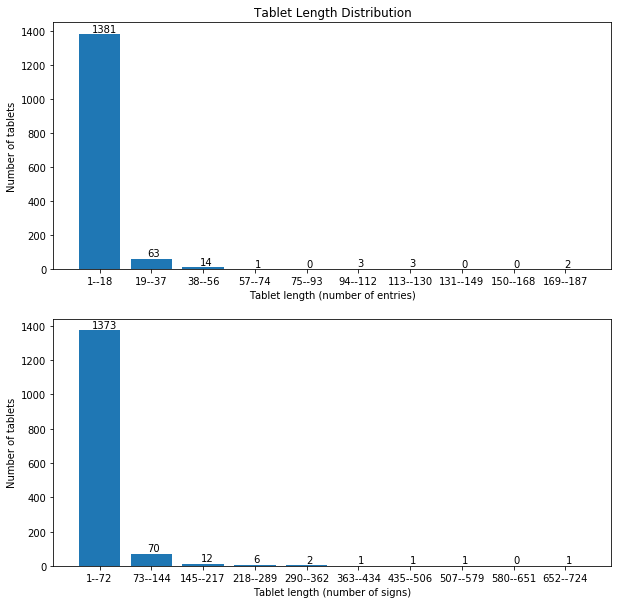

In [4]:
# Import necessary packages:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Compute the length of each tablet, ignoring lacunae and unreadable signs:
length_in_signs = [ 
    len( 
        [ sign for sign in t.linearize( excludeNumeric = False ).upper().split() if sign != '[...]' and sign != 'X'] 
    ) for t in pype.tablets ]

length_in_entries = [
    len(
        list(t.getLines( excludeNumeric = False ))
    ) for t in pype.tablets
]

def draw_histogram( data, ax, num_bins = 10 ):
    # Bin data and get label for each bin:
    bins, labels = np.histogram(data, bins=num_bins )
    labels = [ "%d--%d"%(labels[i]+1,labels[i+1]) for i in range(len(labels)-1) ]

    # Draw the plot:
    x = np.arange( num_bins )
    ax.bar( x, bins )
    ax.set_xticks( x )
    ax.set_xticklabels( labels )

    # Annotate with labels showing exact height of each bar:
    for i, n in enumerate( bins ):
        adjust_x = ((np.log(n) if n != 0 else 0)/50)
        adjust_y = 0.01 * max( bins )
        ax.text(i - adjust_x, n + adjust_y, str(n), color='k')

# Draw the two histograms:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))    

draw_histogram( length_in_entries, ax1 )
ax1.set_title("Tablet Length Distribution")
ax1.set_xlabel("Tablet length (number of entries)")
ax1.set_ylabel("Number of tablets")

draw_histogram( length_in_signs, ax2 )
ax2.set_xlabel("Tablet length (number of signs)")
ax2.set_ylabel("Number of tablets")

plt.style.use('seaborn-whitegrid')
plt.show()

The histograms above show that, regardless of whether we measure a tablet's length as the number of signs it contains or the number of entries it contains, the corpus is overwhelmingly comprised of short texts. We can get a better sense for the length distribution by computing the average and maximum text length and number of numeric and non-numeric signs in each text:

In [5]:
length_in_nonnumeric_signs = [ 
    len( 
        [ sign for sign in t.linearize( excludeNumeric = True ).split() if sign != '[...]' and sign != 'X' ] 
    ) for t in pype.tablets ]

mean_len = sum(length_in_signs) / len(length_in_signs)
mean_len_nonnumeric = sum(length_in_nonnumeric_signs) / len(length_in_nonnumeric_signs)

max_len_i = np.argmax(length_in_signs)
max_len = length_in_signs[max_len_i]
max_len_nonnumeric = length_in_nonnumeric_signs[max_len_i]

print("Mean text length: %.2f signs (%.2f are non-numeric on average)" % (mean_len, mean_len_nonnumeric))
print("Max text length: %d signs (%d are non-numeric)" % (max_len,max_len_nonnumeric))

Mean text length: 27.48 signs (10.15 are non-numeric on average)
Max text length: 724 signs (198 are non-numeric)


We see that most texts are less than 30 signs long, and on average well over half of the signs in a tablet are actually numeric. The non-numeric signs, which are of most interest for the purposes of decipherment, make up a modest proportion of an already small corpus.

# 4. n-Gram Counts

`pype` provides an `ngrams` function to count the number of times a sign or string of signs occurs in the corpus:

In [6]:
unigram_counts        = pype.ngrams( 1, normalizeSigns = False, excludeNumeric = False, excludeCorrections = True )
# if normalizeSigns = True, pype.ngrams will count sign variants as 
# instances of the corresponding base sign instead.
normed_unigram_counts = pype.ngrams( 1, normalizeSigns = True,  excludeNumeric = False, excludeCorrections = True )
bigram_counts         = pype.ngrams( 2, normalizeSigns = False, excludeNumeric = False, excludeCorrections = True )

# if excludeCorrections = True, pype.ngrams will not count signs 
# which have been identified as scribal errors and corrected by
# the transliterator.

print( 'M066 occurs %d times in the corpus.' 
      % ( unigram_counts[ ('M066',) ] ) 
     )
print( 'M066 and its variants occur %d times in the corpus.'
      % ( normed_unigram_counts[ ('M066',) ] ) 
     )
print( 'M388 is followed by M066 %d times in the corpus.'
      % ( bigram_counts[ ('M388', 'M066') ] ) 
     )

M066 occurs 243 times in the corpus.
M066 and its variants occur 293 times in the corpus.
M388 is followed by M066 17 times in the corpus.


We can use this to plot the most frequent $n$-grams for any value of $n$. Edit `N` and `PLOT_SIZE` in the following code block to get longer $n$-grams and adjust the size of the graph:

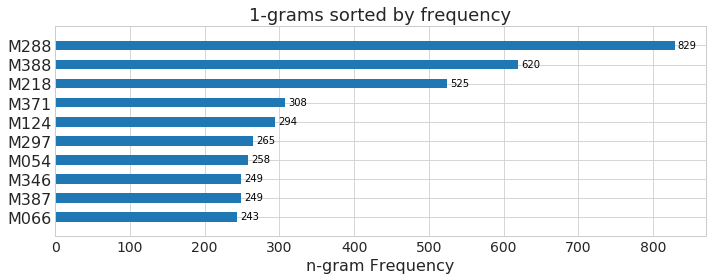

In [7]:
#################################################################
# Edit this to change the length of n-grams in the graph:
N = 1
#################################################################
# Edit this to adjust the size of the plot. May be slow for large plots.
PLOT_SIZE = 10

# Get n-gram counts
ngrams_dict = pype.ngrams( N, normalizeSigns = False, excludeNumeric=True, excludeHeader=False, excludeCorrections=True )
# Convert ngram dictionary to list and sort by frequency:
ngrams_list = sorted([ (sign, ngrams_dict[sign]) for sign in ngrams_dict ],
                     key=lambda sign_count:sign_count[1] )[-PLOT_SIZE:]

fig, ax = plt.subplots(figsize=(10,PLOT_SIZE/2.5))

# Bar graph of ngram counts:
x      = [ count for _,count in ngrams_list ]
labels = [ ', '.join(sign) for sign,_ in ngrams_list ]
y      = np.arange(len(x))
ax.barh(y, x, height=0.5)

# Label each bar with the actual ngram count:
for i, n in enumerate(x):
    adjust_x = 0.005 * max( x )
    adjust_y = -0.125
    ax.text(n + adjust_x, i + adjust_y, str(n), color='k')

# Axis labels
ax.set_xlabel("n-gram Frequency", fontsize=16)

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_title("%d-grams sorted by frequency"%(N), fontsize=18)
# Cut off extra whitespace at the edges
plt.ylim([-1,max(y) + 1])

plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tight_layout()
plt.style.use('seaborn-whitegrid')

plt.show()

## 4.1 Hapaxes

A large proportion of the signary consists of hapaxes, signs which occur only once in the entire corpus:

In [8]:
hapaxes = set(s for s in unigram_counts if unigram_counts[s] == 1)
print("There are %d hapaxes in the signary, including %s..."
      %(len(hapaxes), ", ".join(s[0] for s in list(hapaxes)[:5]))
     )

There are 745 hapaxes in the signary, including M393~G, |M009+M140~A|, M049~B, M251~E, M316~Q...


Many of these hapaxes are variants of other signs, and future work may be able to reduce the size of the signary by identifying whether these variations are meaningful or merely cosmetic.

## 4.2 Pointwise Mutual Information (PMI)

Pointwise mutual information (PMI) is generally useful for identifying meaningful collocations in text. Rare $n$-grams tend to have disproportionately high PMI, however, so on a corpus such as this one ranking $n$-grams by PMI simply produces a list of hapax $n$-grams. The following code block shows the trigrams with the highest PMI, restricted to trigrams which occur at least 5 times in the corpus:

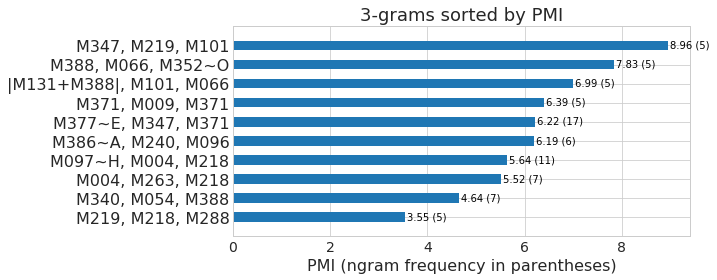

In [9]:
#################################################################
# Edit this to change the length of n-grams in the graph:
N = 3
# Exclude ngrams which do not occur at least THRESHOLD times:
THRESHOLD = 5
#################################################################
# Edit this to adjust the size of the plot. May be slow for large plots.
PLOT_SIZE = 10

ngram_dicts = dict()
ngram_Zs    = dict()
for i in range(N+1):
    ngram_dicts[i] = pype.ngrams( i, normalizeSigns = False, excludeNumeric=True, excludeHeader=False, excludeCorrections=True )
    ngram_Zs[i] = sum(ngram_dicts[i][s] for s in ngram_dicts[i])

def ngram_prob( ngram ):
    n = len(ngram)
    return ngram_dicts[n][ngram] / ngram_Zs[n]
                
def pmi( ngram ):
    ctx,s = ngram[:-1],ngram[-1]
    return (np.log( ngram_prob(ngram) ) - np.log( (ngram_prob(ctx)*ngram_prob((s,))) )) / np.log(2)

ngrams_by_pmi = sorted([(g, pmi(g)) for g in ngram_dicts[N] if ngram_dicts[N][g] >= THRESHOLD],key=lambda x:x[1])
ngrams_list = ngrams_by_pmi

ngrams_list = [ (s,c) for s,c in ngrams_list ][-PLOT_SIZE:]

fig, ax = plt.subplots(figsize=(10,PLOT_SIZE/2.5))

# Bar graph of ngram counts:
x      = [ count for _,count in ngrams_list ]
labels = [ ', '.join(sign) for sign,_ in ngrams_list ]
y      = np.arange(len(x))
ax.barh(y, x, height=0.5)

# Label each bar with the actual ngram count:
for i, n in enumerate(x):
    adjust_x = 0.005 * max( x )
    adjust_y = -0.125
    ax.text(n + adjust_x, i + adjust_y, "%.02f (%d)"%(n, ngram_dicts[N][ngrams_list[i][0]]), color='k')

# Axis labels
ax.set_xlabel("PMI (ngram frequency in parentheses)", fontsize=16)

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_title("%d-grams sorted by PMI"%(N), fontsize=18)
# Cut off extra whitespace at the edges
plt.ylim([-1,max(y) + 1])

plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tight_layout()
plt.style.use('seaborn-whitegrid')

plt.show()

In English, proper nouns tend to have high PMI; at a glance, a similar trend may hold true in proto-Elamite. Many of the signs appearing in the above plot have been speculated to have syllabic or logographic readings which are used for writing anthroponyms (Meriggi 1971:173-174 _La scrittura proto-elamica. Parte Ia:  La scrittura e il contenuto dei testi_). M004, M054, M066, M096, M218, and M371 are some of the most frequent signs in Meriggi's "syllabary", all of which are attested in the above plot. M388, also found above, is speculated to function as a determinative marking personal names, similar to Sumerian 𒁹 _^m_ or 𒇽 _LU2_. Of possible note is the string M340 M054 M388, where this determinative occurs _after_ M054, a sign found in Meriggi's syllabary. In other cases M388 seems to preceed putative personal names, so it is interesting that this deviant usage should appear among the high-PMI trigrams.

## 4.3. Fuzzy $n$-gram Matching

For large values of $n$, there may be very few $n$-grams which occur more than once. Fortunately, there may still be $n$-grams which are similar to one another. This cell computes the edit distance between pairs of $n$-grams and print out pairs which look similar. **This is best used with large values of $n$! May run slowly when $n$ is small.**

In [10]:
#################################################################
# Edit this to change the length of n-grams being compared:
N = 8
#################################################################
# Print out pairs which differ by at most THRESHOLD signs:
THRESHOLD = 1

print("Searching for similar %d-grams..."%(N))

# Computes edit distance between strings:
def levenshtein_dist( ng1, ng2 ):
    if len(ng1) == 0:
        return len(ng2)
    if len(ng2) == 0:
        return len(ng1)
    return min([
        levenshtein_dist(ng1[1:],ng2) + 1,
        levenshtein_dist(ng1,ng2[1:]) + 1,
        levenshtein_dist(ng1[1:],ng2[1:]) + (1 if ng1[0] != ng2[0] else 0)
    ])

# Get ngrams
ngrams = pype.ngrams( N, normalizeSigns = False, excludeNumeric=True, excludeHeader=False, excludeCorrections=True )
for i,ngram1 in enumerate(util.log_progress(ngrams, every=1)):
    for j,ngram2 in enumerate(ngrams):
        if i >= j:
            continue
        if levenshtein_dist(ngram1, ngram2) <= THRESHOLD:
            print(" ".join(ngram1),"\t resembles\t"," ".join(ngram2))
            print("\t"," ".join(ngram1),"occurs",ngrams[ngram1],"times")
            print("\t"," ".join(ngram2),"occurs",ngrams[ngram2],"times")

Searching for similar 8-grams...


M124 M263 M048~D M314 M219 M048~D M240~E M057~B 	 resembles	 M124 M263 M048~D M314 M218 M048~D M240~E M057~B
	 M124 M263 M048~D M314 M219 M048~D M240~E M057~B occurs 1 times
	 M124 M263 M048~D M314 M218 M048~D M240~E M057~B occurs 1 times


Although there are no 8-grams which occur more than once in the corpus, there is a pair of 8-grams which differ by only a single sign. The signs in question, M218 and M219, are visually similar: M218 is a diamond, and M219 is a diamond with a line through the middle. Both have appeared in lists of signs speculated to form part of personal names. Our fuzzy string matching reveals yet another commonality between the two signs, in that they both appear in identical contexts in a very long string of signs.

We recommend adjusting `N` and `THRESHOLD` in the above code block to see other examples of similar strings. We believe that a complete study of the alternations in such strings will reveal novel and useful information about sign usage in proto-Elamite.

# 5. Hierarchical Sign Clustering

In the vein of [Knight et al. (2011)](https://www.aclweb.org/anthology/W11-1202), we can cluster signs based on the contexts in which they appear. The resulting clusters will reveal sets of signs with similar distributions, which may imply some semantic or functional relation between those signs. Future work may build on these results by using neural word embeddings to compute similarity between terms, but the small size of the corpus may make training such a model impractical. For this reason we restrict ourselves to more traditional clustering techniques in this work.

## 5.1. Neighbor-Based Clustering
We begin by constructing a context vector counting how many times each other sign appears immediately to a given sign's left or right. The code for this is available in the `get_contexts` method of the `pe_toolkit_util` module. Using the context vectors returned by `get_contexts`, we use `scipy.cluster.hierarchy.linkage` to compute the similarity between signs and construct a hierarchical clustering based on the computed similarities. Finally, we can visualize the resulting clusters as a dendrogram, and even specify signs of interest to highlight. For ease of interpretation, the dendrogram is limited to signs which occur at least 50 times.

highlighting sign  M157
highlighting sign  M157~A


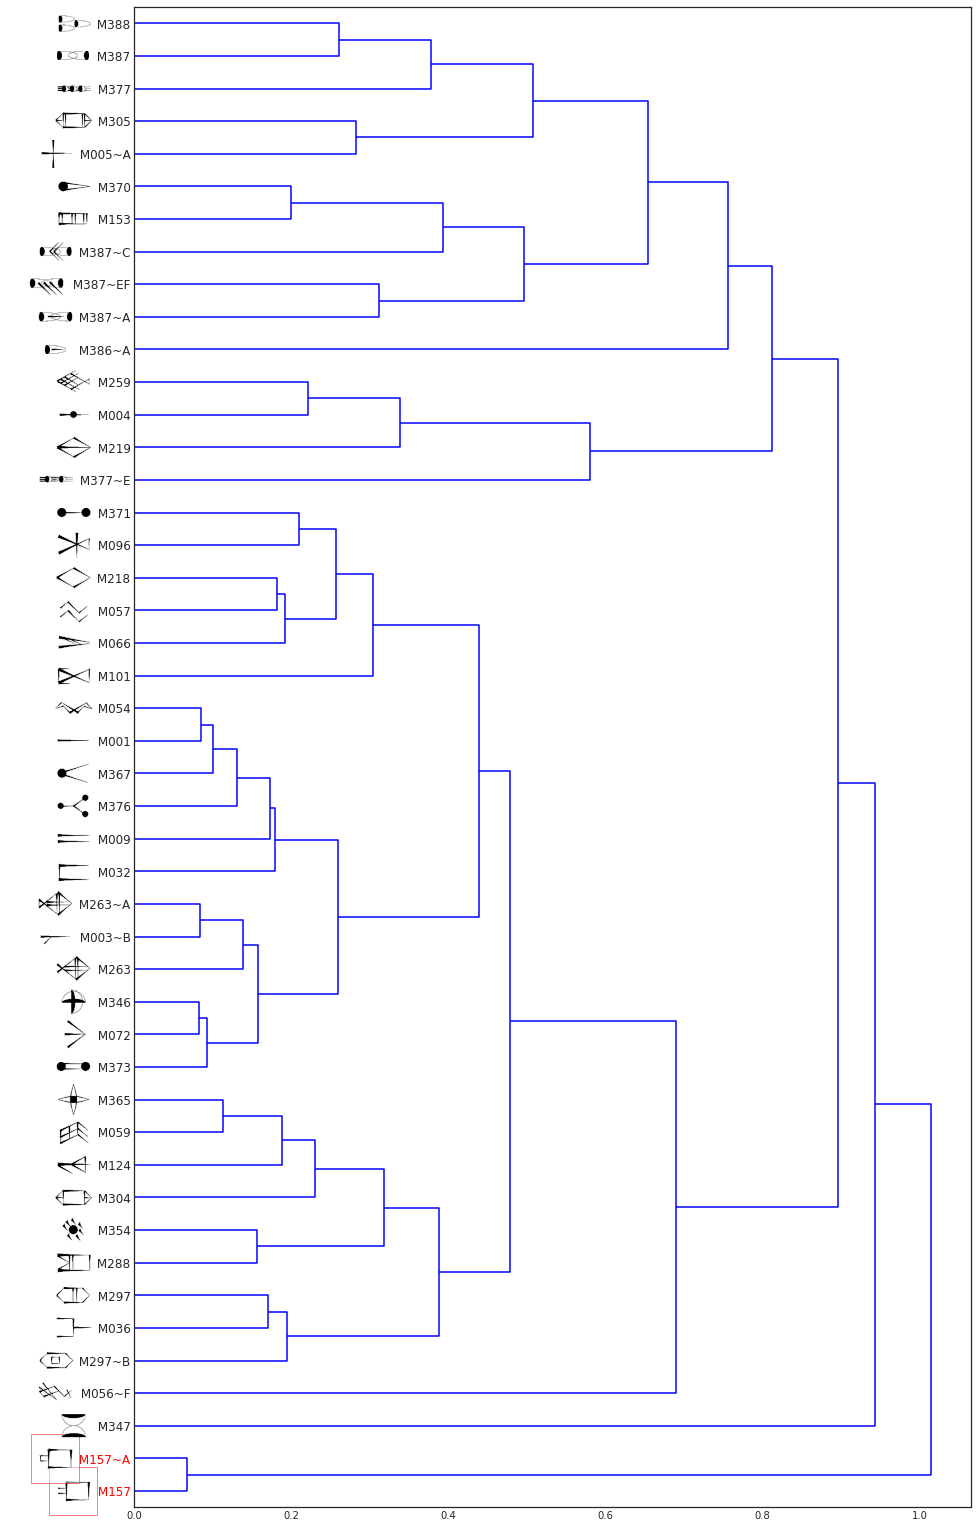

In [11]:
#################################################################
# Edit this to change the number of signs in the dendrogram below:
# The tree will contain all signs which appear at least THRESHOLD
# times in the corpus:
THRESHOLD = 50
# If NORMALIZE is True, then sign variants are collapsed together
# with their corresponding base sign. This may cause some signs
# to display without pictures beside them, as there are no images
# for some base signs.
NORMALIZE = False

from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from PIL import Image
import PIL.ImageOps

# Compute context vectors
labels, contexts = util.get_contexts( threshold=THRESHOLD, normalizeSigns=NORMALIZE )
padded_labels_neighbor = [ "                 %s" % (''.join(labels[i]),) for i in range(len(labels)) ]

# Cluster signs:
clusters_neighbor = linkage(contexts, metric='cosine', method='complete')

def draw_dendrogram(clusters, labels, highlight=[]):
    clusters = [ [c[0],c[1],c[2]+0.05,c[3]] for c in clusters] # add a small offset to make the figure easier to read

    plt.style.use('seaborn-white')

    # Build the dendrogram:
    plt.figure(figsize=(15, 0.6*len(labels)))

    dendrogram(
        clusters,
        leaf_font_size=12.,
        labels=labels,
        orientation='right',
        color_threshold=0.0,
    )

    # Color code symbols of interest to help find them in the diagram:
    ax=plt.gca()
    labels = ax.get_ymajorticklabels()
    label_posns = ax.get_yticks()

    for i,label in enumerate(labels):
        draw_highlight = False
        sign = label.get_text().strip(" ")
        if sign in highlight:
            print("highlighting sign ",sign)
            draw_highlight = True
            label.set_color('red')
        signimg = "./pngs/PE_mainforms/"+sign.upper().replace("~","-")+".png"
        coords = (0,1,label_posns[i]+1,label_posns[i])

        try:
            arr_img = Image.open(signimg)
            arr_img = arr_img.convert("RGBA")

            data = arr_img.getdata()

            newData = []
            for item in data:
                if item[0] == 255 and item[1] == 255 and item[2] == 255:
                    newData.append((255, 255, 255, 0))
                else:
                    newData.append(item)

            arr_img.putdata(newData)


            imagebox = OffsetImage(arr_img, zoom=0.45, interpolation='bicubic')
            imagebox.image.axes = ax
            xy = [0,1*label_posns[i]]
            ab = AnnotationBbox(imagebox, xy,
                                xybox=(-25. + (-9*(len(sign))),0.),
                                xycoords='data',
                                boxcoords="offset points",
                                pad=0,
                                bboxprops=dict(edgecolor='red' if draw_highlight else 'none',alpha=0.5 if draw_highlight else 0)
                                )
            ax.add_artist(ab)
        except FileNotFoundError:
            pass

    plt.show()

draw_dendrogram(clusters_neighbor, padded_labels_neighbor, highlight=["M157", "M157~A"])

The shorter a branch is, the more similar the distribution of signs under that branch. For example, M157 and M157~A are joined by a very short branch, indicating that they are distributed very similarly across the corpus. This is a good benchmark to show that the clustering learns reasonable clusters, as M157 and M157~A are already understood to occur primarily at the beginning of tablets as "header" signs, and no meaningful difference between the two has yet been identified.

This clustering also reveals some less expected results. M387~A and M387~EF are more similar to one another than to any other signs in the corpus, but they are clustered rather far from M387. This may indicate that these variants are semantically or functionally distinct from M387; further investigation of the context these signs appear in may help establish whether this is the case.

Note that we can also compute dendrograms with sign variants collapsed together (so, for example, M157 and M157~A are treated as instances of the same sign). The structure of the dendrogram is broadly similar in this case, but individual signs do move around, and the differences are worth investigating in future work. Set `NORMALIZE` to `True` in the above code block to see the resulting dendrogram.

## 5.2 HMM Clustering

Although neighbor-based clustering was effective for Knight et al. (2011), proto-Elamite is written in a different script and it is possible that this script will respond better to alternative clustering techniques. Furthermore, by performing multiple clusterings with different techniques and looking for commonalities between them, we are able to state with greater certainty that the resulting clusters are meaningful and not simply the result of noise. Given the small size of the proto-Elamite corpus, we believe this kind of noise reduction is very likely to be useful.

One alternative approach is to cluster signs based on the emission probabilities of a hidden Markov model (HMM). The intuition is that, if two signs tend to be emitted by the same state, they are more likely to be related than two signs which are never emitted by the same state.

We begin by training an HMM on the corpus. This may take a few minutes:

In [12]:
#################################################################
# Edit these to change the HMM parameters:
NUM_STATES = 10
NUM_ITERS  = 75
NORMALIZE=False
# Seed to reproduce results in Born et al. 2019:
SEED = 0xbeef

from hmmlearn import hmm

hmm_unigrams = pype.ngrams( 1, normalizeSigns=NORMALIZE, excludeHeader=False, excludeNumeric=False, excludeCorrections=True )
sign_list = [sign for (sign,) in hmm_unigrams]
sign_list.sort()
sign_list.append( '<UNK>' )
sign2i = {sign:i for i,sign in enumerate(sign_list)}    
i2sign = {i:sign for i,sign in enumerate(sign_list)}

tablets_with_real_content = [t for t in pype.tablets 
                             if re.sub( unreadable_signs_regex, "", 
                                       t.linearize( excludeNumeric=True ).upper() 
                                      ).strip() != '']

# Convert corpus to a format hmmlearn will accept:
unk_tokens = ['X', '[...]', '', '...']
data = [ t.linearize( excludeNumeric = False ).upper().split() for t in tablets_with_real_content ]
data = [ [re.sub( transliteration_annotations_regex, "", sign ) for sign in tablet] for tablet in data ]
data = [ [sign if sign not in unk_tokens else '<UNK>' for sign in tablet] for tablet in data ]
if NORMALIZE:
    data = [ [ pype.normalize(sign) for sign in tablet ] for tablet in data ]
data = [ np.array([[sign2i[sign.upper()]] for sign in tablet ]) for tablet in data ]

# Concatenate tablets together to feed them to hmmlearn:
X = np.concatenate(data)
lengths = [len(tablet) for tablet in data]

import warnings
warnings.filterwarnings('ignore')
# hmmlearn has a known issue where division-by-zero warnings occur
# but the model still fits the data. We silence warnings for
# this section to prevent them cluttering the interface.
# See https://github.com/hmmlearn/hmmlearn/issues/146
model = hmm.MultinomialHMM(n_components=NUM_STATES, n_iter=NUM_ITERS, random_state=SEED)
print("Training HMM...")
model.fit(X, lengths)

print("Model converged?",model.monitor_.converged)

Training HMM...
Model converged? True


For each sign, we retrieve the emission probability for that sign from every state in the HMM and compile these probabilities into a feature vector. We cluster signs based on these feature vectors using the same algorithm as in the context-based clustering:

highlighting sign  M218
highlighting sign  M096
highlighting sign  M371
highlighting sign  M057
highlighting sign  M066


<Figure size 1080x1656 with 0 Axes>

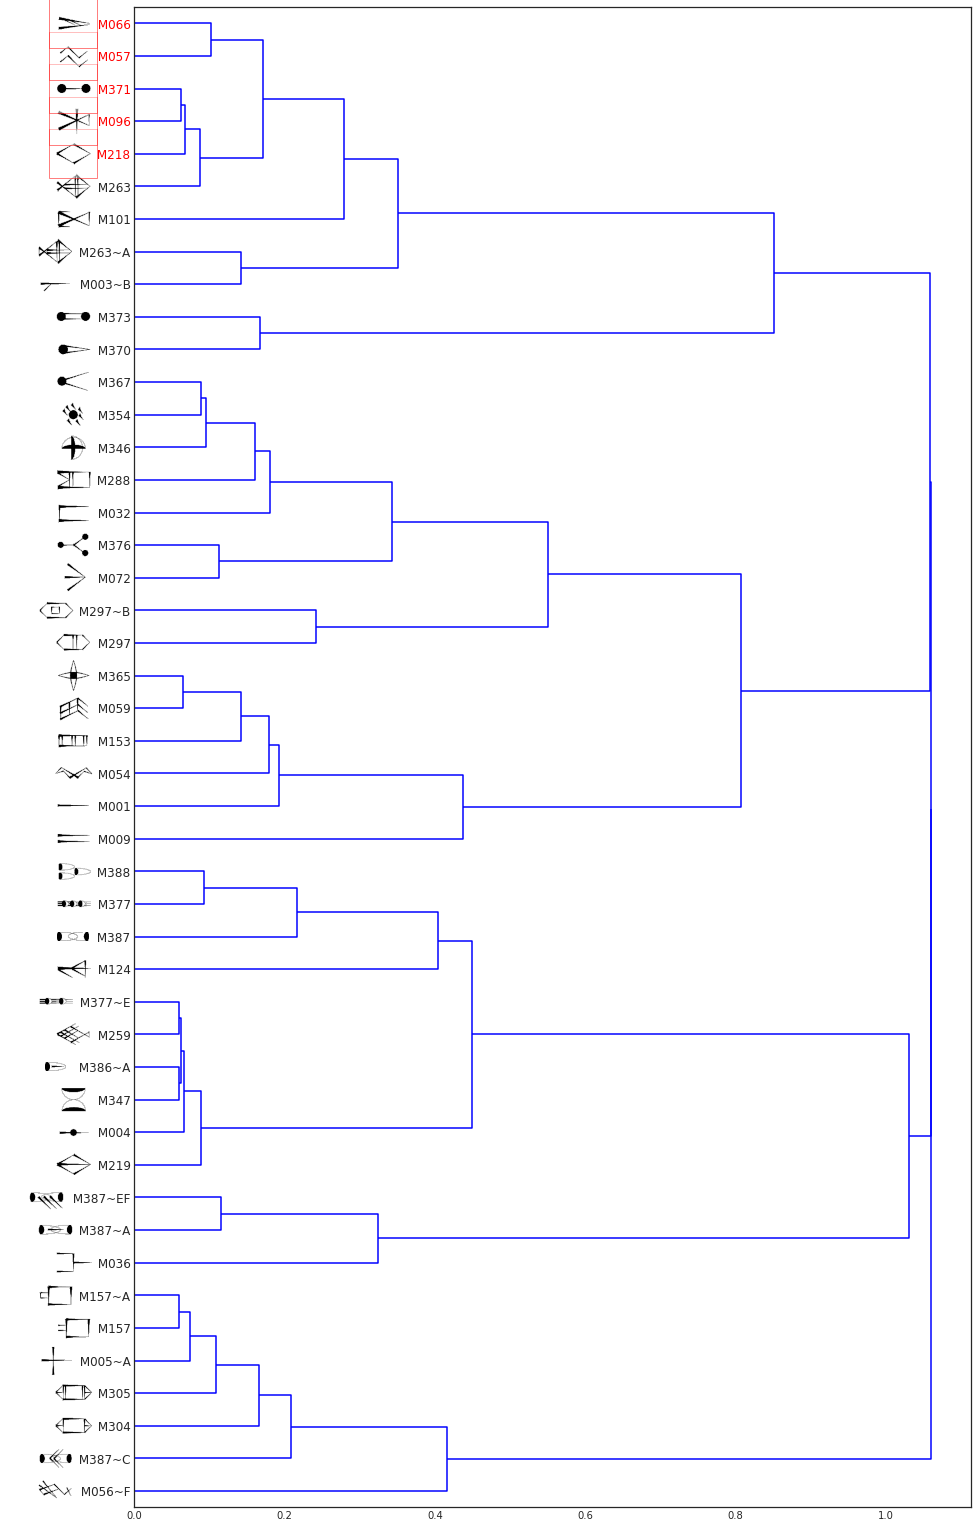

In [13]:
#################################################################
# Edit this to change the number of signs in the dendrogram below:
# The tree will contain all signs which appear at least THRESHOLD
# times in the corpus:
THRESHOLD = 50

# Create feature vectors for each sign using the
# HMM emission probabilities:
cluster_feats = []
cluster_names = []

for i, emission_probs in enumerate(model.emissionprob_.T):
    normalized_probs = np.array([p/sum(emission_probs) for p in emission_probs])
    if i2sign[i] != '<UNK>' and not i2sign[i].startswith('N') and hmm_unigrams[(i2sign[i],)] >= THRESHOLD and '+' not in i2sign[i]:
        cluster_names.append( i2sign[i] )
        cluster_feats.append( normalized_probs )
cluster_feats = np.array( cluster_feats )


# Create dendogram:
plt.figure(figsize=(15, len(cluster_names)/2))
clusters_hmm = linkage(cluster_feats, metric='cosine', method='complete')
clusters_hmm = [ [c[0],c[1],c[2]+0.01,c[3]] for c in clusters_hmm] # Add a small offset to make the figure easier to read
padded_labels_hmm = [ "                 %s" % (''.join(cluster_names[i]),) for i in range(len(cluster_names)) ]

draw_dendrogram(clusters_hmm, padded_labels_hmm, highlight=["M057", "M066", "M096", "M218", "M371"])

At a glance, some similarities to the context-based clustering are apparent. M157 and M157~A again form a tight cluster, as expected, and M387~A and ~EF still cluster together separate from M387. There are even some very large subtrees in common with the neighbor-based dendrogram. M057, M066, M096, M218, and M371 all cluster close together here and in the neighbor-based approach; these signs were previously introduced in the discussion of PMI, where we noted that they are speculated to form parts of personal names.

The similarities between this and the neighbor-based clustering are encouraging, and suggest that there are strong signals in the data which both methods are able to pick up on despite the small corpus size.

We will introduce one more clustering before moving on to a more quantitative analysis of the similarities between these trees.

## 5.3. Brown Clustering

As a third clustering technique, we performed Brown clustering using the generalized-brown implementation found here: https://github.com/sean-chester/generalised-brown

`saved_models/brown.240.120` contains the 120 clusters returned by this algorithm using an active set size of 240. The following code block loads these clusters and converts them into a dendrogram suitable for comparison with the previous clustering methods. We do not provide a way to run the clustering interactively in this notebook, as parts of the clustering implementation are written in C++.

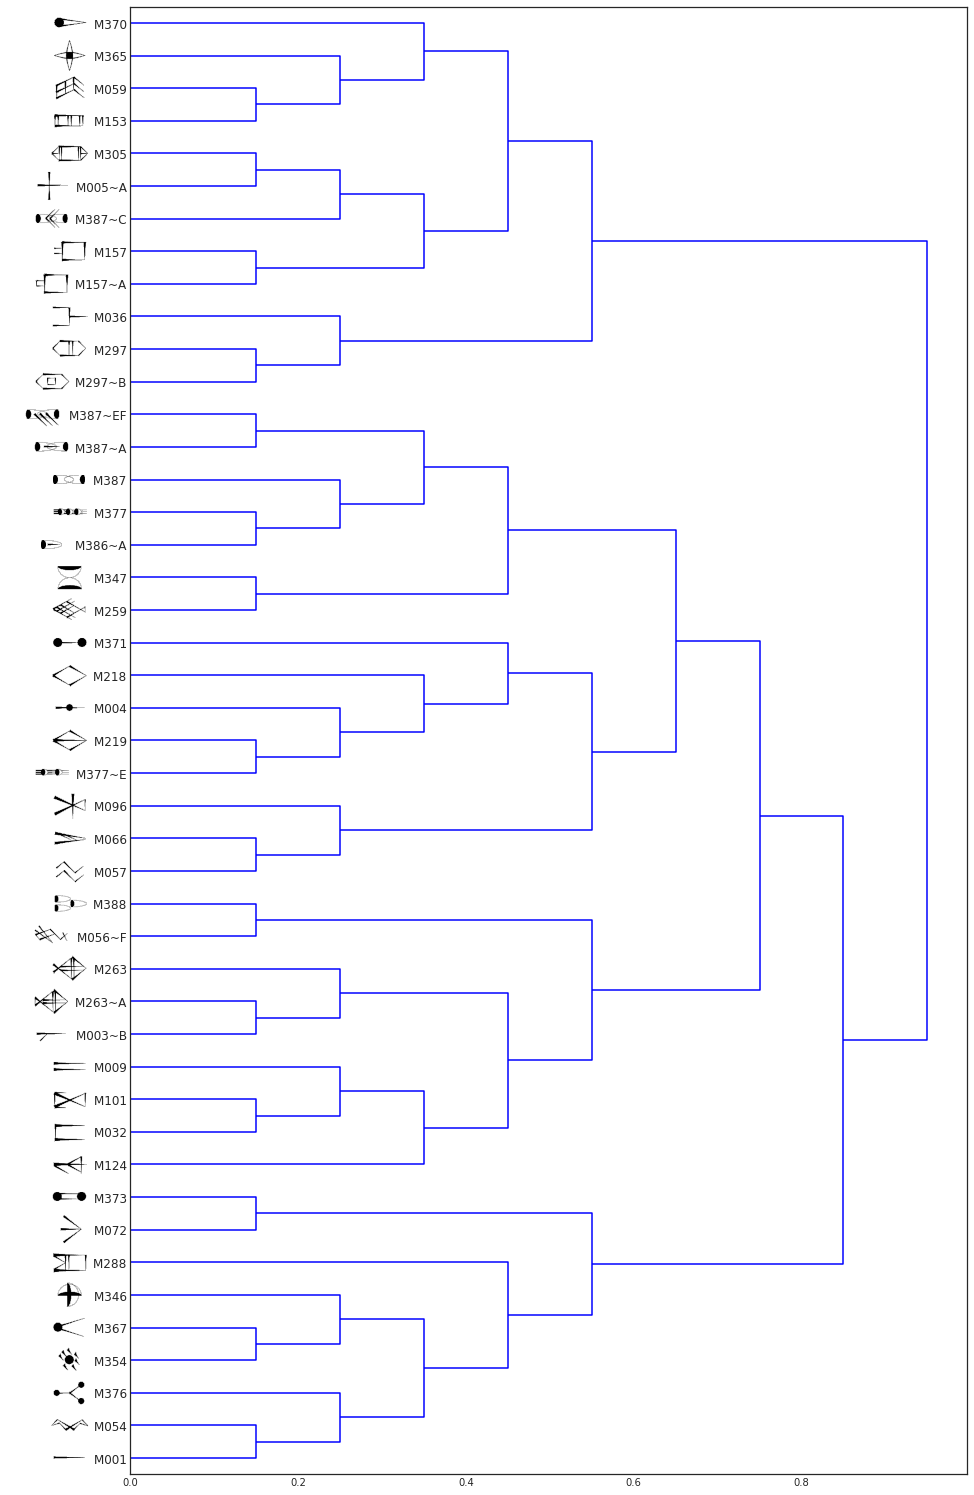

In [14]:
clusters_brown, padded_labels_brown = util.load_brown_model( "saved_models/brown.240.120" )
# To see the clustering learned when sign variants are collapsed, uncomment this line:
# clusters_brown, padded_labels_brown = util.load_brown_model( "saved_models/brown.240.120.collapsed" )
draw_dendrogram( clusters_brown, padded_labels_brown, highlight=[] )

Once again, visual inspection reveals broad similarities to the preceding techniques. The following section attempts to formalize this intuition by looking for the most stable clusters across all three techniques.

## 5.4. Stable Clusters

Given the small size of the proto-Elamite corpus, it is possible that some clusters may result from noise in the data rather than legitimate similarities between signs. By looking for groupings which recur across all three clustering methods, we hope to maximize the likelihood of finding meaningful sign clusters.

We identify stable clusters using the following heuristic: given a set of signs $S$, we compute for each clustering the height of the smallest subtree containing every sign in $S$. If this height is small across every clustering (which we take to mean no greater than $2|S|$), then the signs in $S$ are consistently grouped closely together, and we call $S$ a stable cluster.

The following code searches for stable clusters. The height computed as our heuristic is printed out along with the clusters. Recall that a binary tree with  $|S|$ leaves has a height between $\lceil\log_2 |S|\rceil$ and $|S|-1$. Thus if $S$ is a stable cluster with height $\lceil\log_2 |S|\rceil$, the signs in $S$ always group together as tightly as possible, with no intervening signs in any of the clusterings. By contrast, if $S$ has height greater than $|S|-1$, then at least one of the clusterings groups some intervening signs in with the set $S$.

By default, this code block is limited to finding clusters of at most 3 signs. You can increase the `MAX_CLUSTER_SIZE` parameter to display larger groupings, but be advised that this becomes increasingly slow as `MAX_CLUSTER_SIZE` grows.

In [15]:
#################################################################
# Edit this to change when the algorithm stops looking for 
# larger repeated clusters. May be slow for values above 3.
MAX_CLUSTER_SIZE = 3
# Increase this to skip small clusters.
MIN_CLUSTER_SIZE = 2

# Helper to convert a scipy linkage array
# back into a tree (represented as a nested list):
def get_cluster(linkage, labels, cluster_num):
    n = len(linkage)+1
    if cluster_num < n:
        return labels[int(cluster_num)].strip()
    index = int(cluster_num - n) 
    row = linkage[index]
    c1 = row[0]
    c2 = row[1]
    return [get_cluster(linkage,labels,c1), get_cluster(linkage,labels,c2)]

# Get a representation of each clustering:
all_clusters_brown,_ = util.build_brown_tree( "saved_models/brown.240.120" )
all_clusters_hmm = get_cluster(clusters_hmm, padded_labels_hmm, len(clusters_hmm) + len(padded_labels_hmm) - 1)
all_clusters_neighbor = get_cluster(clusters_neighbor,padded_labels_neighbor, len(clusters_neighbor) + len(padded_labels_neighbor) - 1)

# Helper to flatten a nested list:
def flatten(lst):
    if lst == []:
        return lst
    elif not isinstance(lst,list):
        return [lst]
    else:
        return flatten(lst[0]) + flatten(lst[1:])

# Heuristic to compute closeness of a set of signs 
# in a dendrogram:
def height_of_lowest_subtree_containing(t,signs):
    def height(lst):
        if not isinstance(lst,list):
            return 0
        return 1+max([height(lst[0]),height(lst[1])])
    subtrees = [st for st in util.enum_subtrees(t) if all(s in flatten(st) for s in signs)]
    return height(max(subtrees,key=lambda x:-height(x)))

from itertools import combinations
import math

all_pairwise_dists = []
for set_size in range(MIN_CLUSTER_SIZE,MAX_CLUSTER_SIZE + 1):
    
    print("Searching for repeated clusters of %d signs..."%(set_size))
    min_height = math.ceil(math.log(set_size,2))
    dists = []
    num_combinations = math.factorial(len(padded_labels_neighbor)) / (math.factorial(len(padded_labels_neighbor)-set_size) * math.factorial(set_size))
    for subset in util.log_progress(combinations(padded_labels_neighbor, set_size), every=100, size=num_combinations):
        subset = [sign.strip() for sign in subset]
        try:
            dists.append((subset,max([
                height_of_lowest_subtree_containing(all_clusters_hmm,subset),
                height_of_lowest_subtree_containing(all_clusters_neighbor,subset),
                height_of_lowest_subtree_containing(all_clusters_brown,subset)
            ])))
        except ValueError:
            # If there is no subtree containing all the signs in all three trees,
            # take no action.
            pass
    all_pairwise_dists.append( (set_size, dists) )
    
    # height_threshold determines how tall a subtree can be before
    # the signs within are no longer considered "close" to one another.
    height_threshold = 2*set_size
    best_clusters = sorted([d for d in dists if d[1] <= height_threshold],key=lambda x:x[1])
    
    print("Found %d stable clusters:"%(len(best_clusters)))
    for signs, dist in best_clusters:
        print("\tHeight:",dist,"\tSigns:",", ".join(signs))
    print()

Searching for repeated clusters of 2 signs...


Found 16 stable clusters:
	Height: 1 	Signs: M003~B, M263~A
	Height: 1 	Signs: M157, M157~A
	Height: 1 	Signs: M387~A, M387~EF
	Height: 2 	Signs: M057, M066
	Height: 2 	Signs: M059, M365
	Height: 2 	Signs: M297, M297~B
	Height: 2 	Signs: M377, M387
	Height: 3 	Signs: M004, M377~E
	Height: 3 	Signs: M005~A, M305
	Height: 4 	Signs: M001, M054
	Height: 4 	Signs: M004, M219
	Height: 4 	Signs: M057, M096
	Height: 4 	Signs: M066, M096
	Height: 4 	Signs: M218, M371
	Height: 4 	Signs: M219, M377~E
	Height: 4 	Signs: M288, M354

Searching for repeated clusters of 3 signs...


Found 100 stable clusters:
	Height: 4 	Signs: M004, M219, M377~E
	Height: 4 	Signs: M057, M066, M096
	Height: 5 	Signs: M005~A, M305, M387~C
	Height: 5 	Signs: M057, M066, M218
	Height: 5 	Signs: M057, M066, M371
	Height: 5 	Signs: M057, M096, M218
	Height: 5 	Signs: M057, M096, M371
	Height: 5 	Signs: M057, M218, M371
	Height: 5 	Signs: M066, M096, M218
	Height: 5 	Signs: M066, M096, M371
	Height: 5 	Signs: M066, M218, M371
	Height: 5 	Signs: M096, M218, M371
	Height: 5 	Signs: M377, M386~A, M387
	Height: 6 	Signs: M003~B, M263, M263~A
	Height: 6 	Signs: M004, M219, M259
	Height: 6 	Signs: M004, M219, M377
	Height: 6 	Signs: M004, M219, M386~A
	Height: 6 	Signs: M004, M219, M387
	Height: 6 	Signs: M004, M219, M387~A
	Height: 6 	Signs: M004, M219, M387~EF
	Height: 6 	Signs: M004, M259, M377
	Height: 6 	Signs: M004, M259, M377~E
	Height: 6 	Signs: M004, M259, M386~A
	Height: 6 	Signs: M004, M259, M387
	Height: 6 	Signs: M004, M259, M387~A
	Height: 6 	Signs: M004, M259, M387~EF
	Height: 

This analysis confirms the intuitions from the preceding sections: all three methods group M157 with M157~A and M387~A with M387~EF. An additional group, M003~B and M263~A, also recurs across every technique, and is discussed in Born et al. 2019. 

A limitation of our heuristic is that it finds a large number of overlapping clusters; for example, see all of the clusters containing M057, M066, M096, M218, and M371. This indicates that these are subsets of an even larger stable cluster containing all of these signs. This cluster, which appears to comprise signs used in possible personal names, is also discussed at some length in Born et al. 2019. Notably, M057, M066, and M096 form a tighter group within this larger cluster, as indicated by their lower height in the printout above. It remains for future work to investigate whether this is a meaningful subgroup: perhaps these signs are used ideographically while the other signs in the cluster are syllabic, or vice versa?

Contrary to our intuitive analysis in the preceding sections, M387, M387~A, and M387~EF do form a stable cluster; however, the height of this cluster is 6, indicating that a large number of signs may intervene between M387 and its variants. This may indicate that our threshold for calling a cluster stable is too generous, and we should restrict our analysis to clusters with smaller heights. Alternatively, it may indicate that these signs belong together, but noise in the data causes other unrelated material to intervene between them. Born et al. 2019 focusses its discussion on clusters with small heights, and leaves the interpretation of these broader clusters to future work.

Other small stable clusters which have not yet been discussed include:
- M005~A, M305, and M387~C
- M004 with a variety of other signs (M219, M259, M377...), all belonging to one of Meriggi, Desset, or Dahl's "syllabaries"; these may form another syllabic cluster separate from M057, M066, M096, M218, and M317
- M219 and M377~E
- M377, M386~A, and M387, all of which are either numeric signs (used in a non-numeric context) or clearly derived from numeric signs

We believe that future decipherment work should more closely examine these groups, as the signs in these clusters clearly share some semantic or functional relationship which is strong enough to be detected by multiple distinct clustering techniques. 


# 6. LDA

Latent Dirichlet Allocation (LDA) is a topic modeling algorithm which attempts to group related words into topics and determine which topics are discussed in a given set of documents. Notably, LDA infers topical relationships solely based on rates of term co-occurrence, meaning it can run on undeciphered texts to yield information on which terms may be related. LDA differs from the preceding clusterings in that it also provides a means for grouping tablets based on the topics they discuss, which may reveal genres or other meaningful divisions of the corpus.

Note that the degree of semantic relatedness between words in a topic may vary widely. In English, "kitten", "cat", and "milk" may all belong to a topic of cat-related words; although "kitten" and "cat" are instances of the same class of animal, "kitten" and "milk" are not. Thus we must be careful when interpreting topics from an undeciphered corpus like proto-Elamite: although an undeciphered sign may belong to a topic with other known human or animal signs, this does not necessarily entail that the undeciphered sign is also a human or animal.

The following code block trains an LDA topic model using the `gensim` package. By default the algorithm will learn 10 topics:

In [16]:
#################################################################
# Topic model parameters:
NUM_TOPICS = 10
CHUNKSIZE = 500 
PASSES = 50
ITERATIONS = 5000
EVAL_EVERY=1
# Seed to reproduce model used in Born et al. 2019:
SEED=3628606606

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases

tablets_with_real_content = [t for t in pype.tablets 
                             if re.sub( unreadable_signs_regex, "", 
                                       t.linearize( excludeNumeric=True ).upper() 
                                      ).strip() != '']

unk_tokens = ['X', '[...]', '', '...']
data = [ t.linearize( excludeNumeric = True ).upper().split() for t in tablets_with_real_content ]
data = [ [re.sub( r"\?|#|\[|\]|!", "", sign ) for sign in tablet] for tablet in data ]
data = [ [sign for sign in tablet if sign not in unk_tokens] for tablet in data ]

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    bigram = Phrases(data, min_count=10) 
    # min_count=10 seems to be fairly standard.
    # Due to corpus size might want to be more
    # forgiving and reduce min_count a little?
    trigram = Phrases(bigram[data])

    for i in range(len(data)):
        # Add bigram and trigram features to each document: 
        data[i] = np.append(data[i], [token for token in bigram[data[i]] if '_' in token])
        data[i] = np.append(data[i], [token for token in trigram[data[i]] if '_' in token])

# Convert documents to bags of words:
dictionary = Dictionary(data)
_ = dictionary[0] # id2token is lazy-loaded. Do this to get it in memory.
corpus = [dictionary.doc2bow(doc) for doc in data]
id2word = dictionary.id2token

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # Train LDA model:
    lda_model=LdaModel(
        corpus=corpus, \
        id2word=dictionary, \
        num_topics=NUM_TOPICS, \
        chunksize=CHUNKSIZE, \
        passes=PASSES, \
        iterations=ITERATIONS, \
        eval_every=EVAL_EVERY, \
        random_state=SEED
    )
    coherencemodel = CoherenceModel(
        model=lda_model, \
        texts=data, \
        dictionary=dictionary, \
        coherence='c_v')

    print("Trained LDA topic model.")
    print("Coherence: ",coherencemodel.get_coherence())
    print("Perplexity: ",lda_model.log_perplexity(corpus))

Trained LDA topic model.
Coherence:  0.4855323176945183
Perplexity:  -5.939734601950598


## 6.1 LDA Model Visualization

This cell will produce a visualization of the resulting topic model using [pyLDAvis](https://github.com/bmabey/pyLDAvis). The size of a circle represents the prominence of that topic in the proto-Elamite corpus. The distance between two circles is an approximate measure of the similarity between the corresponding topics. The histogram to the right shows term frequencies; hover over a topic to see the term frequencies within that topic, or hover over a term to see its distribution across the topics.

**This visualization is not available when viewing the static notebook on github: run the notebook locally, on nbviewer, or on Binder to access it.**

In [17]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
    display(vis)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.069240  0.038265       1        1   5.302455
1     -0.023029  0.201220       2        1   8.537845
2     -0.048604 -0.175929       3        1   4.213594
3     -0.174361  0.074868       4        1   7.071535
4      0.158433 -0.007178       5        1  10.365279
5      0.279921 -0.056461       6        1  27.525335
6     -0.210595  0.018669       7        1   5.419681
7     -0.076805 -0.001214       8        1   4.288581
8     -0.014328 -0.254184       9        1  13.057682
9      0.178608  0.161943      10        1  14.218016, topic_info=     Category        Freq              Term       Total  loglift  logprob
23    Default  723.000000              M288  723.000000  30.0000  30.0000
31    Default  222.000000              M346  222.000000  29.0000  29.0000
106   Default  191.000000              M376  191.000000  28.0000  28.0000
6     Default  579.000000              M388  579.000000  27.0000  27.0000
10    Default  482.000000              M218  482.000000  26.0000  26.0000
51    Default  264.000000              M124  264.000000  25.0000  25.0000
32    Default  248.000000              M054  248.000000  24.0000  24.0000
37    Default  243.000000              M297  243.000000  23.0000  23.0000
62    Default  202.000000              M009  202.000000  22.0000  22.0000
39    Default  202.000000              M096  202.000000  21.0000  21.0000
24    Default  291.000000              M371  291.000000  20.0000  20.0000
17    Default  220.000000              M387  220.000000  19.0000  19.0000
3     Default  232.000000              M066  232.000000  18.0000  18.0000
294   Default  111.000000              M036  111.000000  17.0000  17.0000
124   Default  110.000000              M354  110.000000  16.0000  16.0000
67    Default  100.000000              M032  100.000000  15.0000  15.0000
16    Default  106.000000              M370  106.000000  14.0000  14.0000
4     Default  201.000000              M157  201.000000  13.0000  13.0000
48    Default   71.000000            M297~B   71.000000  12.0000  12.0000
91    Default   92.000000              M072   92.000000  11.0000  11.0000
430   Default   86.000000              M367   86.000000  10.0000  10.0000
490   Default   91.000000    |M036+1(N30D)|   91.000000   9.0000   9.0000
193   Default   54.000000            M056~F   54.000000   8.0000   8.0000
235   Default   46.000000  M157_|M195+M057|   46.000000   7.0000   7.0000
84    Default   90.000000            M003~B   90.000000   6.0000   6.0000
799   Default   43.000000         M106_M009   43.000000   5.0000   5.0000
12    Default  163.000000              M263  163.000000   4.0000   4.0000
122   Default  113.000000              M305  113.000000   3.0000   3.0000
69    Default   58.000000            M263~A   58.000000   2.0000   2.0000
287   Default   59.000000              M373   59.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
1011  Topic10    8.514569            M373~A    9.340565   1.8581  -5.5520
84    Topic10   82.309402            M003~B   90.498337   1.8558  -3.2832
953   Topic10    7.998386            M246~B    8.824519   1.8524  -5.6145
923   Topic10    7.982806              M312    8.808899   1.8522  -5.6164
322   Topic10   16.676380           M318~A1   18.425354   1.8509  -4.8797
516   Topic10    7.374688     M387~I_M387~I    8.200715   1.8445  -5.6957
975   Topic10    7.210835            M158~H    8.037009   1.8422  -5.7181
420   Topic10    7.181046  |M370+M046+M370|    8.007038   1.8418  -5.7223
933   Topic10    7.134115            M288~D    7.960154   1.8411  -5.7288
755   Topic10    6.699657            M010~1    7.525712   1.8344  -5.7917
272   Topic10    6.294528              M016    7.120919   1.8273  -5.8541
164   Topic10    6.294036            M352~C    7.120555   1.8273  -5.8541
620   Topic10    6.119283            M010~6    6.9453

## 6.2. Representative Texts

Another way to investigate the topic model is to print the most representative signs and tablets for each topic. For ease of interpretation, the following code block color-codes signs according to the topic they most strongly predict. (Colors may not display depending on where you view the notebook - run a local copy for best results.)

In [18]:
########################################
# This determines how many tablets are
# printed out for each topic in the model:
NUM_REPRESENTATIVE_TABLETS = 3

def get_dominant_topics( ldamodel, corpus ):

    dom_topics = []
    for doc_no, topics in enumerate( ldamodel[corpus] ):
        topics = sorted( topics, key=lambda x:-x[1] )
        for j, ( topic_no, proportion ) in enumerate( topics ):
            if j > 0:
                continue # Only get dominant topic.
            dom_topics.append(
                [
                    doc_no, 
                    int(topic_no)+1, 
                    proportion, 
                    tablets_with_real_content[doc_no].cdliNo
                ]
            )
    return dom_topics

from IPython.display import Image
from numpy import exp
from IPython.core.display import HTML, Image

def topic_colors(t):
    colors = ["#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#7A4900",
              "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87", "#5A0007", 
              "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
              "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", 
              "#D16100", "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", 
              "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", 
              "#C0B9B2", "#C2FF99", "#001E09", "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", 
              "#456D75", "#B77B68", "#7A87A1", "#788D66", "#885578", "#FAD09F", "#FF8A9A"]
    return colors[t]

def color_words(model, doc, text):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    doc_topics, word_topics, phi_values = model.get_document_topics(doc, per_word_topics=True)
    
    word2id = {model.id2word[w]:w for w in model.id2word}
    html = ''
    for word in text:
        word_ = word
        word = word.replace("[","").replace("]","")
        if word not in word2id:
            html += '<span style="color:#000;">'+word_+' </span>'
            continue
        phis = [(t,) for t in phi_values if t[0] == word2id[word]][0]
        best_topic = max(phis[0][1], key=lambda x:x[1])[0] if len(phis[0][1])>0 else -1
        best_topic_phi = max(phis[0][1], key=lambda x:x[1])[1] if len(phis[0][1])>0 else 0
        color = topic_colors(best_topic)
        color = [ int(color[1:3],16), int(color[3:5],16), int(color[5:7],16) ]
        scale_factor = exp(best_topic_phi) / (1+exp(best_topic_phi))
        scale_factor = 1
        color = [int(scale_factor*c) for c in color]
        color = '#%02x%02x%02x'%tuple(color)
        html += '<span style="color:'+color+';">'+word_+' </span>'
    return html

def show_tablet( index ):
    for i, row in enumerate(lda_model[corpus]):
        if i != index:
            continue
        row = sorted(row, key=lambda x: -x[1])
        t = tablets_with_real_content[index]
        
        html = '<div style="overflow:auto; margin-left:2em; max-width:1000px;">'
        for line in t.getLines(excludeNumeric=False):
            if line[0] is not None:
                signs=line[0].replace("?","").replace('#','').upper()
                html += color_words(lda_model, corpus[i], 
                        signs.split(" ")
                       )
            html += "<span style='color:#bbb;'>, "+(line[1] if line[1] is not None else '')+"</span><br />"
        html += "</div>"
        return html
        
        
print("Formatting topic data...")
dominant_topics = get_dominant_topics( lda_model, corpus )
dominant_topics = sorted(dominant_topics,key=lambda x:x[1])
dominant_topics = [ (i+1, [row for row in dominant_topics if row[1]==i+1]) 
                   for i in range( lda_model.num_topics ) ]

html = '<html><body>' 

for i, grp in dominant_topics:
    html+="<h1>Topic %d:</h1><hr/>"%(i)
    wp = lda_model.show_topic(int(i-1))
    html+="<p><h2>Representative terms:</h2><br/>" +("<br/>".join(["<span style='margin-left:2em;'>%s (%.2f%%)</span>"%(word,100*prop) for (word, prop) in wp]))+"</p>"
    html+="<p><h2>Representative tablets:</h2><br/></p>"
    representative_tablets = sorted(grp,key=lambda x:-x[2])[:NUM_REPRESENTATIVE_TABLETS]
    for row in representative_tablets:
        index = row[0]
        index = int(index)
        html+="<h3>"+row[3]+"</h3>"
        html+="<b>Topic composition:</b><br/>"
        for t_num, perc_cont in sorted(lda_model[corpus][index],key=lambda x:-x[1]):
            html+="<span style='margin-left:2em;color:%s;'>Topic %d: %.2f%%</span><br/>"%(topic_colors(t_num),t_num+1,100*perc_cont)
        html+="<b>Transliteration</b><br/>Words are colored according to the topic they most strongly represent."
        html += show_tablet(index)

html+="</body></html>"
# Save HTML to separate file for easier viewing:
# outfile = open("LDA_report.html","w")
# outfile.write(html)
# outfile.close()
display(HTML(html))

Formatting topic data...


Using these topic summaries in conjunction with the visualization above, we are able to interpret many of the learned topics; these interpretations are summarized in Born et al. 2019. Some topics, such as topic 5, have no clear interpretation based on our current understanding of proto-Elamite. It is possible that this topic is merely a collection of leftover material that does not fit nicely into any of the other topics. However, a cursory examination of the representative tablets for topic 5 suggests that many are sealed, and closer analysis confirms this to be the case:

In [19]:
sealed = defaultdict(int)
total  = defaultdict(int)

for topic_no,topic_tablets in dominant_topics:
    for index,_,_,_ in topic_tablets:
        t = tablets_with_real_content[index]
        if t.sealed:
            sealed[topic_no] += 1
        total[topic_no] += 1

for i in range(1,10+1):
    print("Topic %d:\t %d sealed\t(%.2f%%)"%(int(i),sealed[i],100*sealed[i]/total[i]))

Topic 1:	 12 sealed	(11.76%)
Topic 2:	 21 sealed	(12.00%)
Topic 3:	 7 sealed	(8.24%)
Topic 4:	 9 sealed	(7.96%)
Topic 5:	 31 sealed	(21.53%)
Topic 6:	 38 sealed	(12.58%)
Topic 7:	 5 sealed	(9.43%)
Topic 8:	 9 sealed	(9.78%)
Topic 9:	 14 sealed	(6.90%)
Topic 10:	 5 sealed	(3.85%)


Of the tablets where topic 5 is the dominant topic, 22% are sealed; topic 6 has the next-highest proportion of seals at just 13%. Although seals are recorded in the CDLI transliterations, `pype` removes these annotations when loading the corpus, and the LDA model has no information about their presence or absence. The fact that topic 5 has such a high number of sealed texts may therefore indicate that the LDA model is picking up on some similarity between these texts which we are not currently aware of. 

## 6.3 Topic Stability

LDA is a probabilistic algorithm, and it may return different topics when run multiple times on the same data. [Mäntylä et al. (2018)](https://arxiv.org/pdf/1808.08098.pdf) provide a technique for finding stable topics by looking for similarities across multiple executions of the algorithm. 

These authors suggest learning a model with $t$ topics $k$ times to get $t*k$ topic-term vectors. Running $k$-medoids on the topic-term vectors produces $t$ topic clusters. The stability of a cluster is defined as the rank-biased overlap (RBO) between all vectors in that cluster:

$$RBO(T1, T2, p, d) = \frac{X_d}{d}\cdot p^d + \frac{1-p}{p}\sum_{i=1}^{d}\frac{X_i}{i}\cdot p^i$$

where T1 and T2 are two ranked lists (topic-term vectors), $d$ is the evaluation depth (evaluation only considers the $d$ most predictive words for each topic), and $X_d$ is the size of the intersection of the first $d$ entries in T1 with the first $d$ entries in T2. $p$ determines the degree to which order is taken into account. $p=1$ ignores order; as $p$ decreases, more weight is assigned to terms which are more highly predictive. The authors suggest $p=0.9$ 

The following code applies Mäntylä et al.'s method to our data to determine which topics are stable. For reference, output from the particular run discussed in Born et al. 2019 is included in `saved_models/stability.txt`. In order to make this code block run in a reasonable amount of time, we limit it to averaging over 30 models; you may adjust this by editing `n_runs`. It remains for future work to determine which topics are most stable in the limit, by increasing `n_runs` until the set of stable topics stops changing between runs. 

**Even limited to 30 models, this code block can be very slow.** You can safely skip it, as no later code depends on anything computed here. 

In [20]:
# Relearn an LDA model n_runs times:
n_runs = 30

# LDA model parameters:
num_topics = 30
chunksize = 500
passes = 50
iterations = 5000
eval_every = 1

import random
# kmedoids implementation due to Bauckhage, C. Numpy/scipy Recipes for Data
# Science: k-Medoids Clustering[R]. Technical Report, University of Bonn, 2015.
# https://github.com/letiantian/kmedoids
import kmedoids

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    topic_term_matrices = None
    print("Training %d LDA models..."%(n_runs))
    for run in range(n_runs):
        seed=random.randint(0,0xffffffff)
        print("\tModel %d: seed %d"%(run, seed))

        stability_model=LdaModel(
            corpus=corpus, \
            id2word=dictionary, \
            num_topics=num_topics, \
            chunksize=chunksize, \
            passes=passes, \
            iterations=iterations, \
            eval_every=eval_every, \
            random_state=seed
        )
        
        if topic_term_matrices is None:
            topic_term_matrices = stability_model.get_topics()
        else:
            topic_term_matrices = np.concatenate( [topic_term_matrices, stability_model.get_topics()] )
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn import metrics
    from sklearn.preprocessing import normalize as sknormalize
    
    n_clusters=num_topics

    lda_stability_data=topic_term_matrices
    from sklearn.metrics.pairwise import pairwise_distances
    D = pairwise_distances(lda_stability_data, metric='euclidean')
    M, C = kmedoids.kMedoids(D, n_clusters)
    
def RBO(T1, T2, p, d):
    T1 = T1[:d]
    T2 = T2[:d]
    Xd = len(set(T1).intersection(set(T2)))
    return (Xd/d)*(p**d) + ((1-p)/p)*sum( [(len(set(T1[:i]).intersection(T2[:i]))/i) * (p**i) for i in range(1,d+1)] )

def var(term, ts, d):
    ts=[ t[:d] for t in ts ]
    indices = [ t.index(term) for t in ts if term in t ]
    mu = sum(indices)/len(indices)
    v = 0
    for i in range(d):
        p_i = len([t for t in ts if t[i] == term])
        v += p_i*((i - mu)**2)
    return mu,v**0.5

clusters = []
d=10
# Compute pairwise RBO within each cluster
# Print mean RBO per cluster
for label in C:
    stability = []
    counts = defaultdict(int)
    for i in range(len(C[label])):
        point_idx = C[label][i]
        terms = np.argsort(data[point_idx])[::-1]
        for term in terms[:d]:
            counts[term]+=1
        for j in range(len(C[label])):
            if j<=i:
                continue
            point_idx_2 = C[label][j]
            terms_2 = np.argsort(data[point_idx_2])[::-1]
            stability.append( RBO(terms, terms_2, 0.9, d) )
    if len(stability) == 0:
        continue
    counts=({ id2word[t]:counts[t]/len(C[label]) for t in counts })
    stability = sum(stability)/len(stability)
    terms = np.argsort(data[M[label]])[::-1]
    clusters += [ ([id2word[term] for term in terms[:d]], stability, counts) ]

print("\nTopics ranked by stability:")
clusters.sort(key=lambda x:-x[1])
for c in clusters:
    print()
    print("topic stability:\t%f"%(c[1],))
    print("\t\t{0:<20}{1:>15}".format("term","frequency"))
    term_stability = [(term,c[2][term]) for term in c[0] ]
    term_stability.sort(key=lambda x:-x[1])
    print("\t\t{0:<20}{1:>15.3f}".format(term_stability[0][0],term_stability[0][1]))
    for t,c in term_stability[1:]:
        print("\t\t{0:<20}{1:>15.3f}".format(t,c))


Training 30 LDA models...
	Model 0: seed 1512468269
	Model 1: seed 1542404754
	Model 2: seed 462947820
	Model 3: seed 2812911482
	Model 4: seed 1481665161
	Model 5: seed 2964920013
	Model 6: seed 215036720
	Model 7: seed 2472806397
	Model 8: seed 487289074
	Model 9: seed 1343248740
	Model 10: seed 1187839550
	Model 11: seed 4138433783
	Model 12: seed 3116687084
	Model 13: seed 2566676960
	Model 14: seed 1468936248
	Model 15: seed 2191306982
	Model 16: seed 2244127738
	Model 17: seed 163126972
	Model 18: seed 2099464708
	Model 19: seed 987279723
	Model 20: seed 619768940
	Model 21: seed 657307788
	Model 22: seed 434656
	Model 23: seed 2446727812
	Model 24: seed 1293536377
	Model 25: seed 1917776284
	Model 26: seed 2970530657
	Model 27: seed 2377126869
	Model 28: seed 3486030984
	Model 29: seed 3518368696

Topics ranked by stability:

topic stability:	0.406524
		term                      frequency
		M136~I                        0.923
		M066                          0.923
		M131~E       

## 7. Conclusion

Beyond reproducing our published results, we hope this notebook serves as a means for readers to experiment with our code and see what different models are capable of learning about proto-Elamite. As demonstrated in the introductory sections, the `pype` package included with this notebook provides an off-the-shelf interface for working with the proto-Elamite corpus, a copy of which is included in `data/cdli_atf_20180602.txt.bz2`. 

If you use this code in your research, we ask that you cite

> Born, Logan, Kate Kelley, Nishant Kambhatla, Carolyn Chen, and Anoop Sarkar. 2019. Sign clustering and topic extraction in proto-Elamite. In *Proceedings of the Third Joint SIGHUM Workshop on Computational Linguistics for Cultural Heritage, Social Sciences, Humanities and Literature (LaTeCH-CLfL-2019)*. Minneapolis, Minnesota.

A link to the paper will be added closer to the date of the workshop.


## 7.1 Acknowledgments

We wish to thank the [CDLI](https://cdli.ucla.edu) for their efforts producing and publishing the transliterations used in this work. 

Our implementation of [Mäntylä et al. (2018)](https://arxiv.org/pdf/1808.08098.pdf) uses the [$k$-medoids implementation](https://github.com/letiantian/kmedoids) due to [Bauckhage 2015](https://www.researchgate.net/publication/272351873_NumPy_SciPy_Recipes_for_Data_Science_k-Medoids_Clustering).

## 7.2. Additional Resources

The [CDLI wiki](http://cdli.ox.ac.uk/wiki/doku.php?id=proto-elamite) provides a summary of the proto-Elamite script and an extensive bibliography for further reading. 

Questions and feedback can be addressed to loborn@sfu.ca.